In [1]:
import pandas as pd

# Dateiname
dateiname = "./data/produkt_tu_termin_20240413_20251014_00183.txt"

# CSV-Datei laden mit ; als Trennzeichen
df = pd.read_csv(dateiname, sep=';')

# Optional: ersten Blick auf die Daten
df.head()

,STATIONS_ID,MESS_DATUM,QN_4,TT_TER,RF_TER,eor
0,183,2024041306,9,9.9,90.0,eor
1,183,2024041312,9,14.0,82.0,eor
2,183,2024041318,9,12.1,85.0,eor
3,183,2024041406,9,9.0,78.0,eor
4,183,2024041412,9,10.6,69.0,eor


In [2]:
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H')

In [3]:
df.columns = df.columns.str.strip()

In [4]:
df.head()

,STATIONS_ID,MESS_DATUM,QN_4,TT_TER,RF_TER,eor
0,183,2024-04-13 06:00:00,9,9.9,90.0,eor
1,183,2024-04-13 12:00:00,9,14.0,82.0,eor
2,183,2024-04-13 18:00:00,9,12.1,85.0,eor
3,183,2024-04-14 06:00:00,9,9.0,78.0,eor
4,183,2024-04-14 12:00:00,9,10.6,69.0,eor


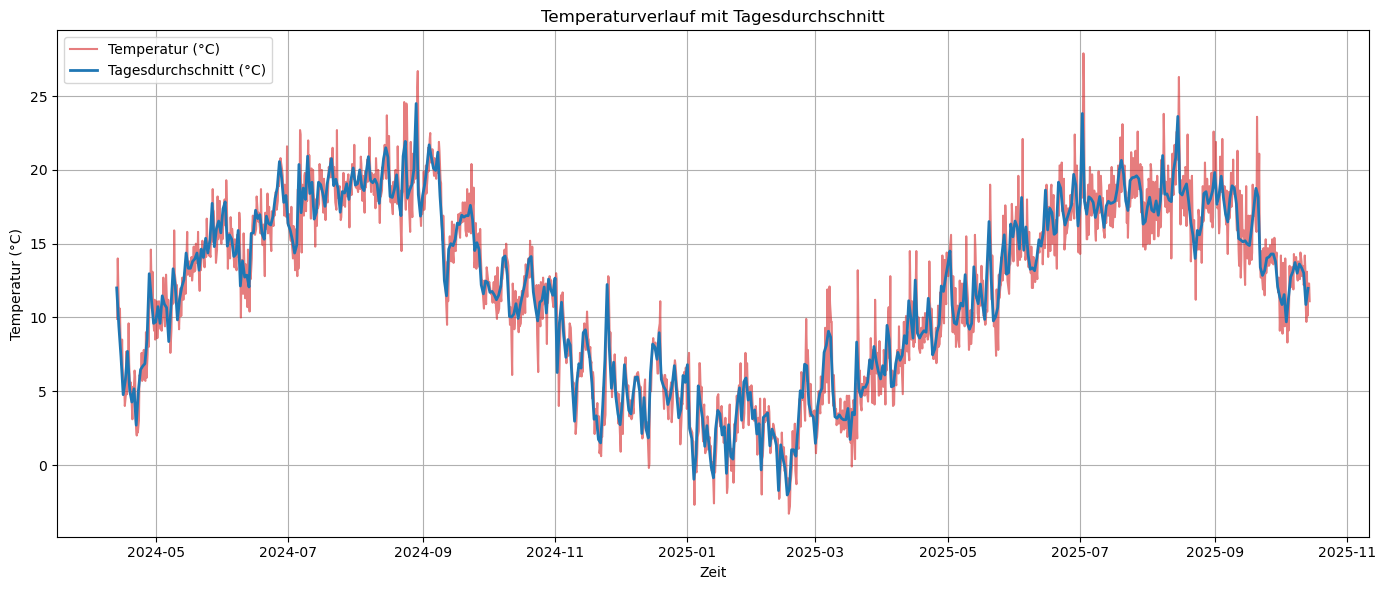

In [7]:
import matplotlib.pyplot as plt

df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H')

# EOR-Spalte entfernen, falls vorhanden
if 'eor' in df.columns:
    df = df.drop(columns=['eor'])

# Tagesdurchschnitt berechnen
df['Datum'] = df['MESS_DATUM'].dt.date
tagesmittel = df.groupby('Datum')['TT_TER'].mean()

# Plot erstellen
plt.figure(figsize=(14, 6))

# Originale Temperaturwerte (rot)
plt.plot(df['MESS_DATUM'], df['TT_TER'], label='Temperatur (°C)', color='tab:red', alpha=0.6)

# Tagesmitteltemperatur (blau)
plt.plot(tagesmittel.index, tagesmittel.values, label='Tagesdurchschnitt (°C)', color='tab:blue', linewidth=2)

# Achsen und Legende
plt.xlabel('Zeit')
plt.ylabel('Temperatur (°C)')
plt.title('Temperaturverlauf mit Tagesdurchschnitt')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Plot anzeigen
plt.show()

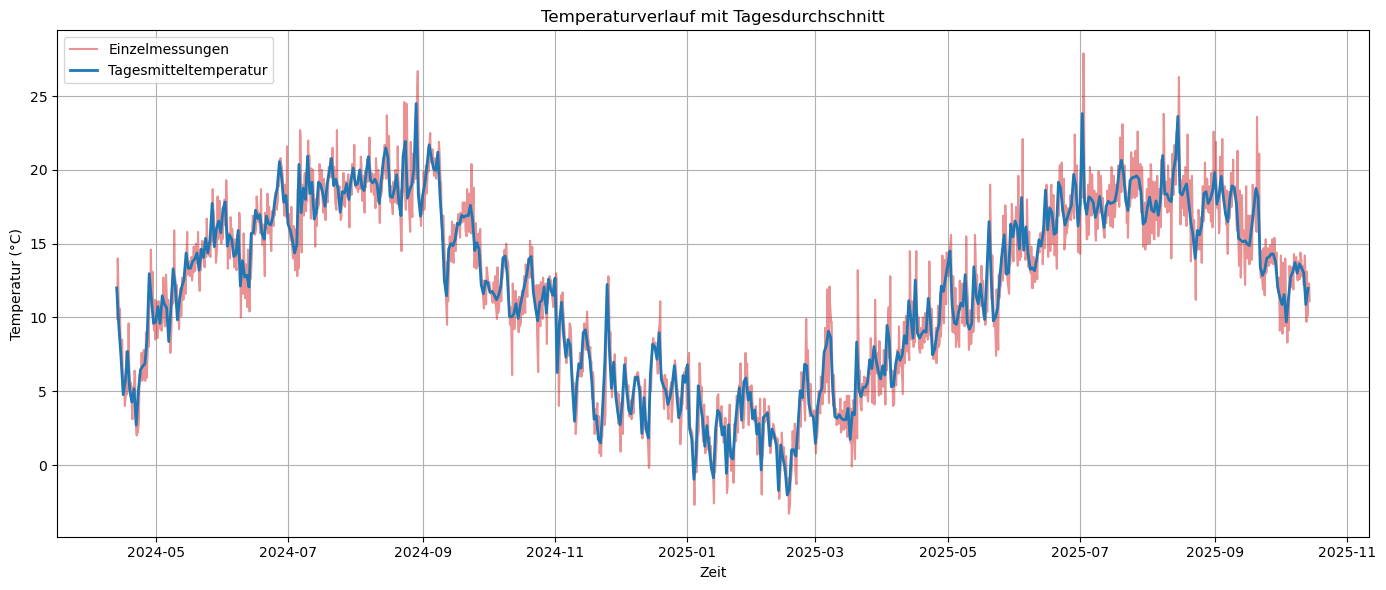

,Datum,TT_TER
0,2024-04-13,12.000000
1,2024-04-14,9.400000
2,2024-04-15,7.300000
3,2024-04-16,4.766667
4,2024-04-17,5.766667


In [9]:
# Tagesmitteltemperatur berechnen
df['Datum'] = df['MESS_DATUM'].dt.floor('D')  # nur Datumsteil (als datetime)
tagesmittel = df.groupby('Datum')['TT_TER'].mean().reset_index()

# Plot erstellen
plt.figure(figsize=(14, 6))

# Einzelmessungen plotten
plt.plot(df['MESS_DATUM'], df['TT_TER'], label='Einzelmessungen', color='tab:red', alpha=0.5)

# Tagesmitteltemperaturen plotten
plt.plot(tagesmittel['Datum'], tagesmittel['TT_TER'], label='Tagesmitteltemperatur', color='tab:blue', linewidth=2)

# Formatierung
plt.xlabel('Zeit')
plt.ylabel('Temperatur (°C)')
plt.title('Temperaturverlauf mit Tagesdurchschnitt')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()
tagesmittel.head()

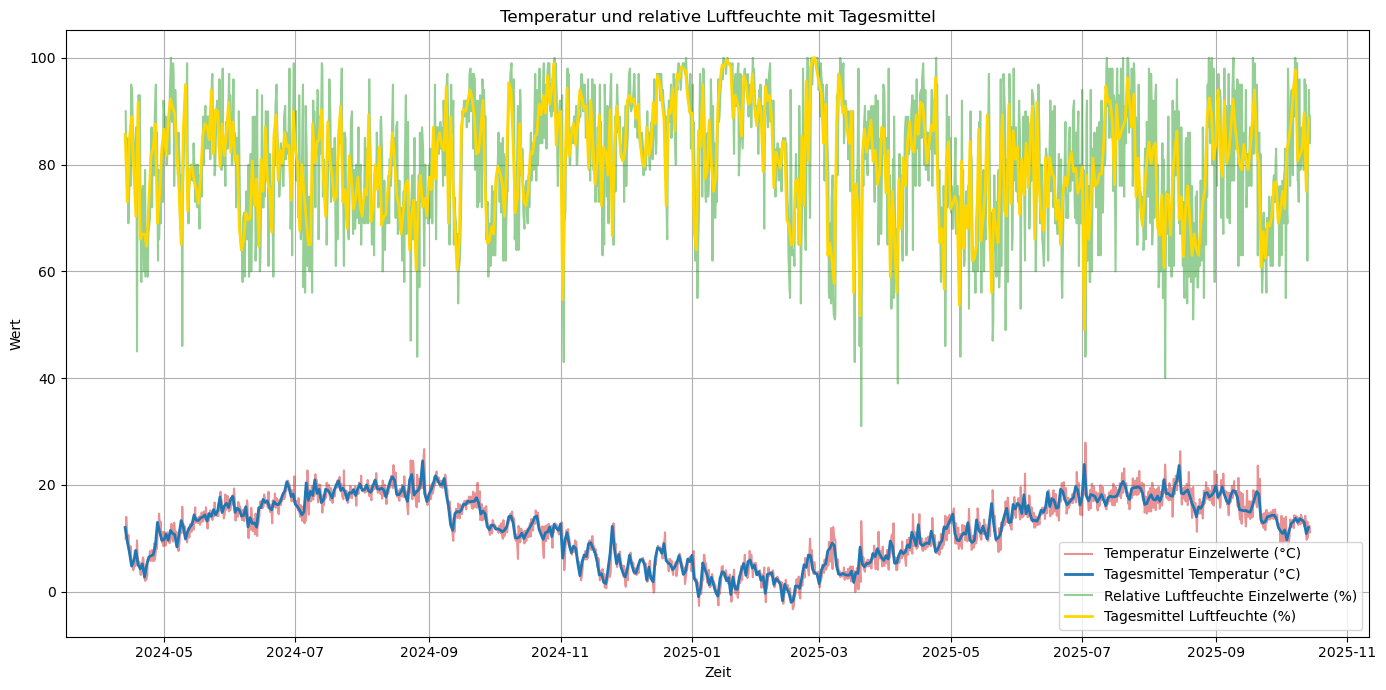

In [10]:
# Tagesmittel für Temperatur und relative Luftfeuchte berechnen
df['Datum'] = df['MESS_DATUM'].dt.floor('D')
tagesmittel = df.groupby('Datum').agg({
    'TT_TER': 'mean',
    'RF_TER': 'mean'
}).reset_index()

# Plot erstellen
plt.figure(figsize=(14, 7))

# Temperatur (rot)
plt.plot(df['MESS_DATUM'], df['TT_TER'], label='Temperatur Einzelwerte (°C)', color='tab:red', alpha=0.5)
plt.plot(tagesmittel['Datum'], tagesmittel['TT_TER'], label='Tagesmittel Temperatur (°C)', color='tab:blue', linewidth=2)

# Relative Luftfeuchte (grün)
plt.plot(df['MESS_DATUM'], df['RF_TER'], label='Relative Luftfeuchte Einzelwerte (%)', color='tab:green', alpha=0.5)
plt.plot(tagesmittel['Datum'], tagesmittel['RF_TER'], label='Tagesmittel Luftfeuchte (%)', color='gold', linewidth=2)

# Achsen und Titel
plt.xlabel('Zeit')
plt.ylabel('Wert')
plt.title('Temperatur und relative Luftfeuchte mit Tagesmittel')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

In [11]:
# Extrahiere Datum und Stunde
df['Datum'] = df['MESS_DATUM'].dt.floor('D')
df['Stunde'] = df['MESS_DATUM'].dt.hour

# Filter für die Stunden 6, 12, 18
df_6 = df[df['Stunde'] == 6].set_index('Datum')['TT_TER']
df_12 = df[df['Stunde'] == 12].set_index('Datum')['TT_TER']
df_18 = df[df['Stunde'] == 18].set_index('Datum')['TT_TER']

# 06->12: Temperaturdifferenz am selben Tag
diff_6_12 = df_12 - df_6

# 12->18: Temperaturdifferenz am selben Tag
diff_12_18 = df_18 - df_12

# 18->06: Temperaturdifferenz von 18 Uhr bis 6 Uhr des Folgetags
# Verschiebe die 6-Uhr Werte um einen Tag zurück, damit sie auf denselben Index wie 18 Uhr fallen
diff_18_6 = df_6.shift(-1) - df_18

# Durchschnittliche Temperaturänderungen berechnen (ohne NaNs)
avg_diff_6_12 = diff_6_12.mean()
avg_diff_12_18 = diff_12_18.mean()
avg_diff_18_6 = diff_18_6.mean()

print(f"Durchschnittliche Temperaturänderung 06->12 Uhr: {avg_diff_6_12:.2f} °C")
print(f"Durchschnittliche Temperaturänderung 12->18 Uhr: {avg_diff_12_18:.2f} °C")
print(f"Durchschnittliche Temperaturänderung 18->06 Uhr (Folgetag): {avg_diff_18_6:.2f} °C")

Durchschnittliche Temperaturänderung 06->12 Uhr: 1.85 °C
Durchschnittliche Temperaturänderung 12->18 Uhr: -1.04 °C
Durchschnittliche Temperaturänderung 18->06 Uhr (Folgetag): -0.82 °C


Korrelationskoeffizient zwischen Luftfeuchte (6-12 Uhr) und Temperaturänderungsabweichung (12-18 Uhr): 0.346


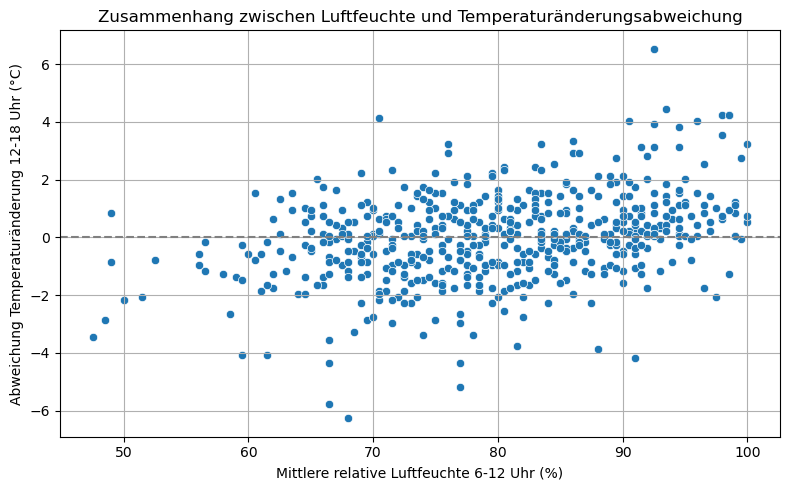

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV laden
df = pd.read_csv("./data/produkt_tu_termin_20240413_20251014_00183.txt", sep=';')

# Datum konvertieren
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H')

# EOR-Spalte entfernen falls vorhanden
if 'eor' in df.columns:
    df = df.drop(columns=['eor'])

# Datum und Stunde extrahieren
df['Datum'] = df['MESS_DATUM'].dt.floor('D')
df['Stunde'] = df['MESS_DATUM'].dt.hour

# Durchschnittliche Temperaturänderungen berechnen (wie vorher)
df_6 = df[df['Stunde'] == 6].set_index('Datum')['TT_TER']
df_12 = df[df['Stunde'] == 12].set_index('Datum')['TT_TER']
df_18 = df[df['Stunde'] == 18].set_index('Datum')['TT_TER']

avg_diff_12_18 = (df_18 - df_12).mean()

# Für jeden Tag tatsächliche Temperaturänderung 12->18
temp_change_12_18 = (df_18 - df_12).rename('temp_change_12_18')

# Relative Luftfeuchte 6-12 Uhr: Mittelwert pro Tag über Stunden 6,9,12 (je nach Verfügbarkeit)
# Da wir nur 6,12,18 Uhr haben, nehmen wir Mittelwert der 6 und 12 Uhr
rf_6 = df[df['Stunde'] == 6].set_index('Datum')['RF_TER']
rf_12 = df[df['Stunde'] == 12].set_index('Datum')['RF_TER']

rf_mean_6_12 = pd.concat([rf_6, rf_12], axis=1).mean(axis=1).rename('rf_mean_6_12')

# Daten zusammenführen
analysis_df = pd.concat([temp_change_12_18, rf_mean_6_12], axis=1).dropna()

# Berechne die Abweichung der Temperaturänderung von Durchschnitt
analysis_df['temp_change_dev'] = analysis_df['temp_change_12_18'] - avg_diff_12_18

# Korrelationsanalyse
corr = analysis_df[['rf_mean_6_12', 'temp_change_dev']].corr().iloc[0,1]
print(f"Korrelationskoeffizient zwischen Luftfeuchte (6-12 Uhr) und Temperaturänderungsabweichung (12-18 Uhr): {corr:.3f}")

# Scatterplot
plt.figure(figsize=(8,5))
sns.scatterplot(data=analysis_df, x='rf_mean_6_12', y='temp_change_dev')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Mittlere relative Luftfeuchte 6-12 Uhr (%)')
plt.ylabel('Abweichung Temperaturänderung 12-18 Uhr (°C)')
plt.title('Zusammenhang zwischen Luftfeuchte und Temperaturänderungsabweichung')
plt.grid(True)
plt.tight_layout()
plt.show()

Korrelationskoeffizient zwischen Luftfeuchte (12-18 Uhr) und Temperaturänderungsabweichung (18-6 Uhr Folgetag): 0.229


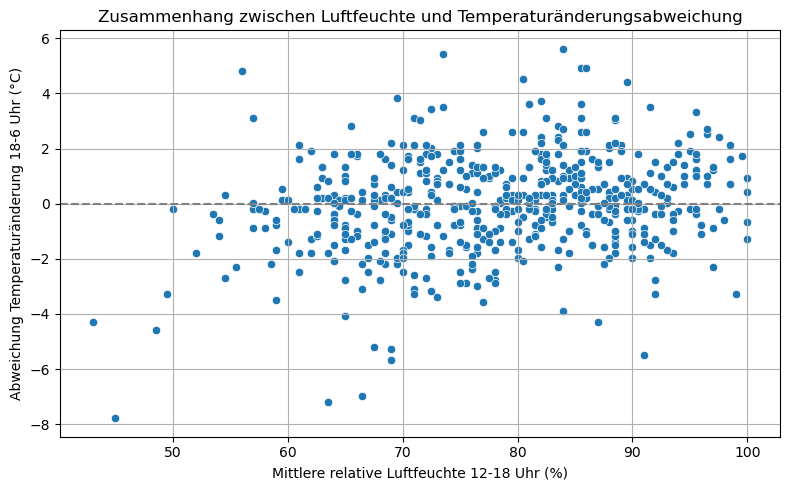

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV laden
df = pd.read_csv("./data/produkt_tu_termin_20240413_20251014_00183.txt", sep=';')

# Datum konvertieren
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H')

# EOR-Spalte entfernen falls vorhanden
if 'eor' in df.columns:
    df = df.drop(columns=['eor'])

# Datum und Stunde extrahieren
df['Datum'] = df['MESS_DATUM'].dt.floor('D')
df['Stunde'] = df['MESS_DATUM'].dt.hour

# Temperaturwerte nach Stunde als Series mit Datum Index
df_6 = df[df['Stunde'] == 6].set_index('Datum')['TT_TER']
df_12 = df[df['Stunde'] == 12].set_index('Datum')['TT_TER']
df_18 = df[df['Stunde'] == 18].set_index('Datum')['TT_TER']

# Durchschnittliche Temperaturänderung 18->6 Uhr (Folgetag)
avg_diff_18_6 = (df_6.shift(-1) - df_18).mean()

# Tatsächliche Temperaturänderung 18->6 Uhr (Folgetag) pro Tag
temp_change_18_6 = (df_6.shift(-1) - df_18).rename('temp_change_18_6')

# Relative Luftfeuchte 12-18 Uhr Mittelwert
rf_12 = df[df['Stunde'] == 12].set_index('Datum')['RF_TER']
rf_18 = df[df['Stunde'] == 18].set_index('Datum')['RF_TER']
rf_mean_12_18 = pd.concat([rf_12, rf_18], axis=1).mean(axis=1).rename('rf_mean_12_18')

# Daten zusammenführen
analysis_df = pd.concat([temp_change_18_6, rf_mean_12_18], axis=1).dropna()

# Abweichung der Temperaturänderung vom Durchschnitt
analysis_df['temp_change_dev'] = analysis_df['temp_change_18_6'] - avg_diff_18_6

# Korrelationskoeffizient
corr = analysis_df[['rf_mean_12_18', 'temp_change_dev']].corr().iloc[0,1]
print(f"Korrelationskoeffizient zwischen Luftfeuchte (12-18 Uhr) und Temperaturänderungsabweichung (18-6 Uhr Folgetag): {corr:.3f}")

# Scatterplot
plt.figure(figsize=(8,5))
sns.scatterplot(data=analysis_df, x='rf_mean_12_18', y='temp_change_dev')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Mittlere relative Luftfeuchte 12-18 Uhr (%)')
plt.ylabel('Abweichung Temperaturänderung 18-6 Uhr (°C)')
plt.title('Zusammenhang zwischen Luftfeuchte und Temperaturänderungsabweichung')
plt.grid(True)
plt.tight_layout()
plt.show()
#Erwartete positive Korelation: hohe Luftfeuchtigkeit am Abend, wenig Abkühlung über Nacht, da viel Wärmekapazität der Luft

            min   max  amplitude
Datum                           
2024-04-13  9.9  14.0        4.1
2024-04-14  8.6  10.6        2.0
2024-04-15  6.6   8.5        1.9
2024-04-16  4.0   5.3        1.3
2024-04-17  4.8   7.7        2.9


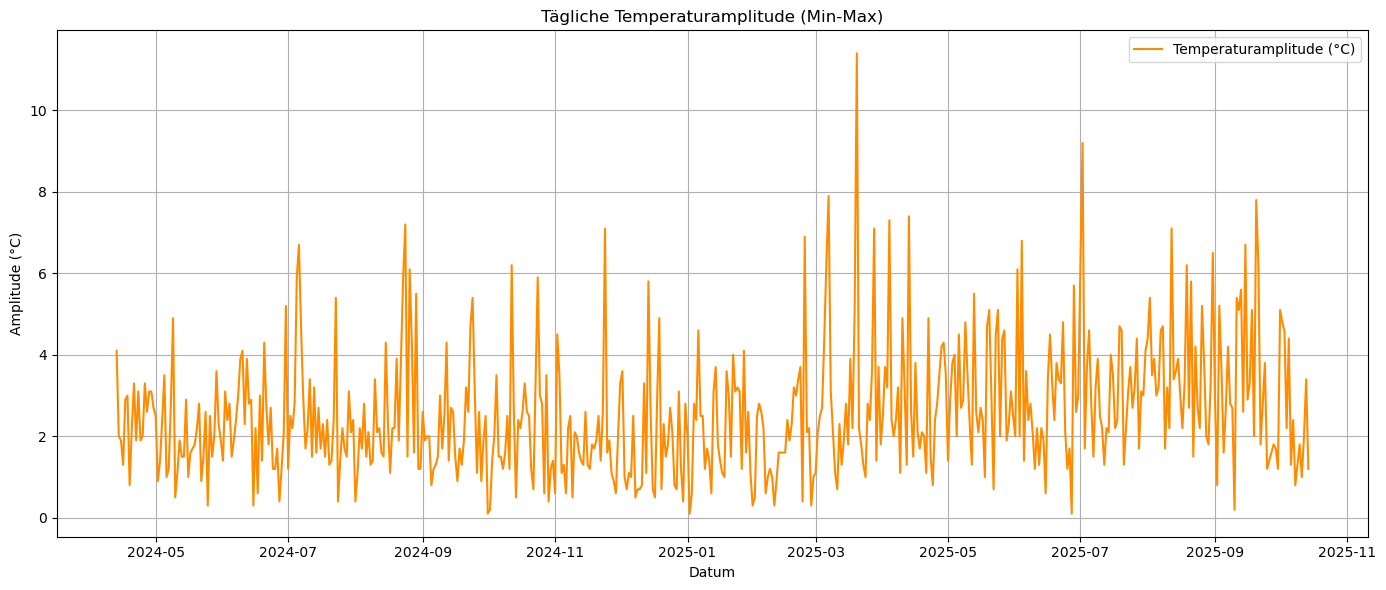

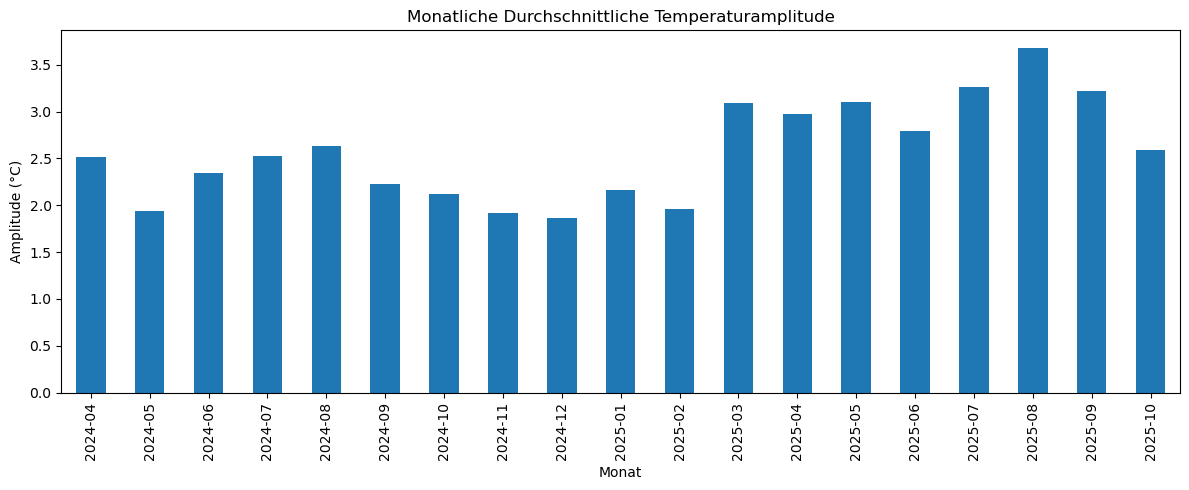

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV laden
df = pd.read_csv("./data/produkt_tu_termin_20240413_20251014_00183.txt", sep=';')

# Datum konvertieren
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H')

# EOR-Spalte entfernen falls vorhanden
if 'eor' in df.columns:
    df = df.drop(columns=['eor'])

# Datum ohne Uhrzeit extrahieren
df['Datum'] = df['MESS_DATUM'].dt.floor('D')

# Tagesminimum und -maximum (aus vorhandenen Messungen) berechnen
tagesextreme = df.groupby('Datum')['TT_TER'].agg(['min', 'max'])

# Temperaturamplitude berechnen
tagesextreme['amplitude'] = tagesextreme['max'] - tagesextreme['min']

# Überblick anzeigen
print(tagesextreme.head())

# Plot: Amplitude über die Zeit
plt.figure(figsize=(14, 6))
plt.plot(tagesextreme.index, tagesextreme['amplitude'], label='Temperaturamplitude (°C)', color='darkorange')
plt.xlabel('Datum')
plt.ylabel('Amplitude (°C)')
plt.title('Tägliche Temperaturamplitude (Min-Max)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()
tagesextreme['Monat'] = tagesextreme.index.to_series().dt.to_period('M')
monat_mittel = tagesextreme.groupby('Monat')['amplitude'].mean()
monat_mittel.plot(kind='bar', figsize=(12,5), title='Monatliche Durchschnittliche Temperaturamplitude')
plt.ylabel('Amplitude (°C)')
plt.tight_layout()
plt.show()


Korrelation zwischen Temperaturamplitude und mittlerer relativer Luftfeuchte: -0.296


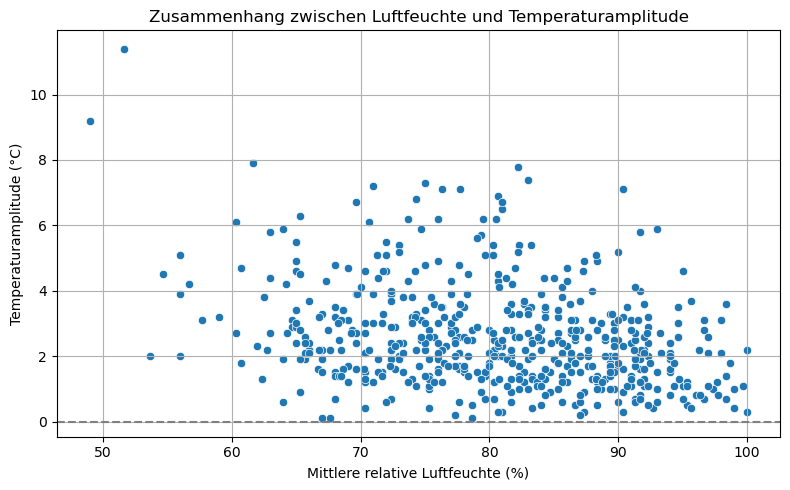

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV laden
df = pd.read_csv("./data/produkt_tu_termin_20240413_20251014_00183.txt", sep=';')
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H')
if 'eor' in df.columns:
    df = df.drop(columns=['eor'])

# Datum extrahieren
df['Datum'] = df['MESS_DATUM'].dt.floor('D')

# Temperaturextreme je Tag
tagesextreme = df.groupby('Datum')['TT_TER'].agg(['min', 'max'])
tagesextreme['amplitude'] = tagesextreme['max'] - tagesextreme['min']

# Mittlere tägliche relative Luftfeuchte
tagesfeuchte = df.groupby('Datum')['RF_TER'].mean().rename('rf_mean')

# Kombinieren
df_corr = tagesextreme.join(tagesfeuchte).dropna()

# Korrelation berechnen
corr = df_corr['amplitude'].corr(df_corr['rf_mean'])
print(f"Korrelation zwischen Temperaturamplitude und mittlerer relativer Luftfeuchte: {corr:.3f}")

# Scatterplot
plt.figure(figsize=(8,5))
sns.scatterplot(x='rf_mean', y='amplitude', data=df_corr)
plt.title('Zusammenhang zwischen Luftfeuchte und Temperaturamplitude')
plt.xlabel('Mittlere relative Luftfeuchte (%)')
plt.ylabel('Temperaturamplitude (°C)')
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()
#Erwartete negative Korrelation. Hohe Luftfeuche-> niedriger TempUnterschied

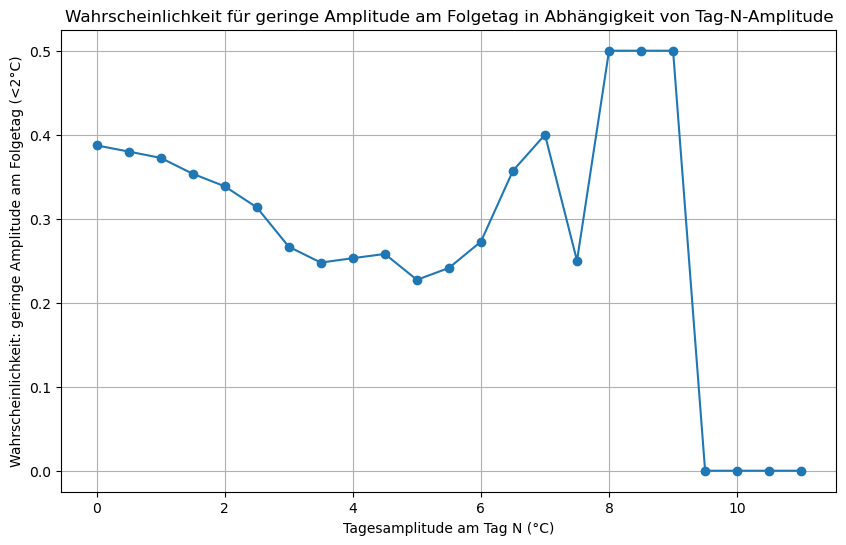

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSV laden und vorbereiten
df = pd.read_csv("./data/produkt_tu_termin_20240413_20251014_00183.txt", sep=';')
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H')
if 'eor' in df.columns:
    df = df.drop(columns=['eor'])
df['Datum'] = df['MESS_DATUM'].dt.floor('D')

# Tagesmin, -max, Amplitude
tagesextreme = df.groupby('Datum')['TT_TER'].agg(['min', 'max'])
tagesextreme['amplitude'] = tagesextreme['max'] - tagesextreme['min']

# Amplitude am Folgetag hinzufügen
tagesextreme['amplitude_next'] = tagesextreme['amplitude'].shift(-1)

# Definiere kleinen Amplitudengrenzwert für Folgetag (z.B. unter 2°C)
threshold_next = 2.0

# Spalte ob Folgetag geringe Amplitude hat (True/False)
tagesextreme['next_day_small_amp'] = tagesextreme['amplitude_next'] < threshold_next

# Jetzt prüfen wir für verschiedene Schwellenwerte der Tagesamplitude (Tag N),
# wie wahrscheinlich es ist, dass der Folgetag eine kleine Amplitude hat.

thresholds = np.arange(0, 15, 0.5)  # von 0 bis 15 Grad in 0.5er-Schritten
probabilities = []

for th in thresholds:
    subset = tagesextreme[tagesextreme['amplitude'] > th]
    if len(subset) > 0:
        prob = subset['next_day_small_amp'].mean()  # Anteil Tage mit kleiner Folgetagsamplitude
    else:
        prob = np.nan
    probabilities.append(prob)

# Plot
plt.figure(figsize=(10,6))
plt.plot(thresholds, probabilities, marker='o')
plt.xlabel('Tagesamplitude am Tag N (°C)')
plt.ylabel('Wahrscheinlichkeit: geringe Amplitude am Folgetag (<2°C)')
plt.title('Wahrscheinlichkeit für geringe Amplitude am Folgetag in Abhängigkeit von Tag-N-Amplitude')
plt.grid(True)
plt.show()


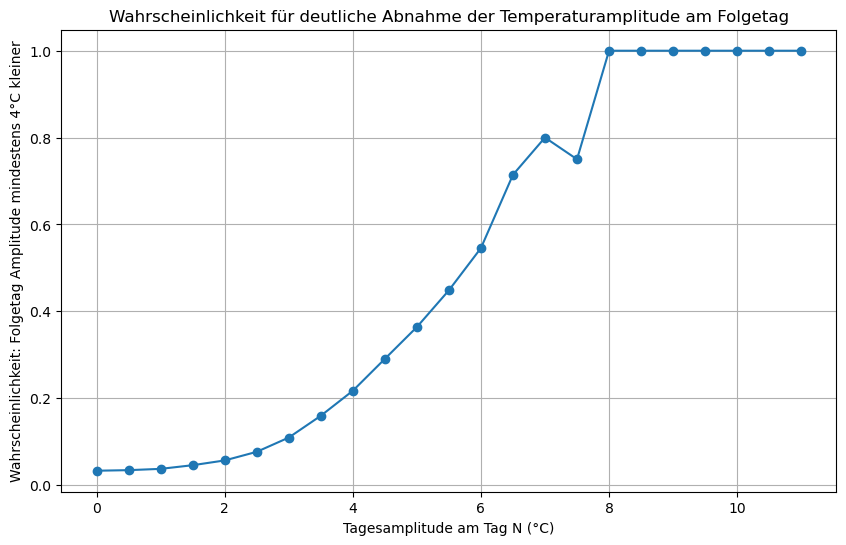

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSV laden und vorbereiten
df = pd.read_csv("./data/produkt_tu_termin_20240413_20251014_00183.txt", sep=';')
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H')
if 'eor' in df.columns:
    df = df.drop(columns=['eor'])
df['Datum'] = df['MESS_DATUM'].dt.floor('D')

# Tagesmin, -max, Amplitude
tagesextreme = df.groupby('Datum')['TT_TER'].agg(['min', 'max'])
tagesextreme['amplitude'] = tagesextreme['max'] - tagesextreme['min']

# Amplitude am Folgetag hinzufügen
tagesextreme['amplitude_next'] = tagesextreme['amplitude'].shift(-1)

# Definiere kleine Amplitude am Folgetag als "mindestens 4 Grad kleiner als Vortag"
tagesextreme['next_day_small_amp'] = tagesextreme['amplitude_next'] < (tagesextreme['amplitude'] - 4)

# Wahrscheinlichkeiten für verschiedene Schwellenwerte der Tagesamplitude (Tag N)
thresholds = np.arange(0, 20, 0.5)
probabilities = []

for th in thresholds:
    subset = tagesextreme[tagesextreme['amplitude'] > th]
    if len(subset) > 0:
        prob = subset['next_day_small_amp'].mean()
    else:
        prob = np.nan
    probabilities.append(prob)

# Plot
plt.figure(figsize=(10,6))
plt.plot(thresholds, probabilities, marker='o')
plt.xlabel('Tagesamplitude am Tag N (°C)')
plt.ylabel('Wahrscheinlichkeit: Folgetag Amplitude mindestens 4°C kleiner')
plt.title('Wahrscheinlichkeit für deutliche Abnahme der Temperaturamplitude am Folgetag')
plt.grid(True)
plt.show()


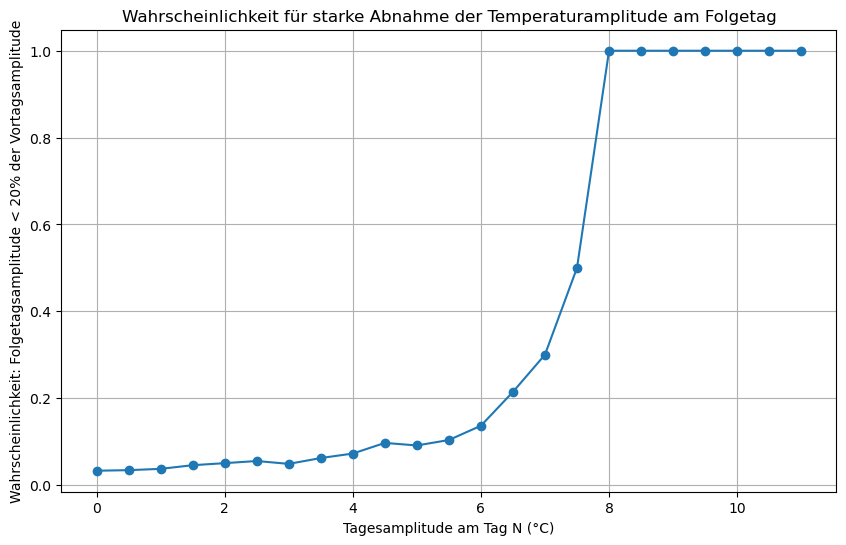

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSV laden und vorbereiten
df = pd.read_csv("./data/produkt_tu_termin_20240413_20251014_00183.txt", sep=';')
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H')
if 'eor' in df.columns:
    df = df.drop(columns=['eor'])
df['Datum'] = df['MESS_DATUM'].dt.floor('D')

# Tagesmin, -max, Amplitude berechnen
tagesextreme = df.groupby('Datum')['TT_TER'].agg(['min', 'max'])
tagesextreme['amplitude'] = tagesextreme['max'] - tagesextreme['min']

# Amplitude am Folgetag hinzufügen
tagesextreme['amplitude_next'] = tagesextreme['amplitude'].shift(-1)

# Kleine Folgetagsamplitude definiert als < 25% der Amplitude des Vortages
tagesextreme['next_day_small_amp'] = tagesextreme['amplitude_next'] < (tagesextreme['amplitude'] * 0.2)

# Wahrscheinlichkeiten für verschiedene Schwellenwerte der Tagesamplitude (Tag N)
thresholds = np.arange(0, 20, 0.5)
probabilities = []

for th in thresholds:
    subset = tagesextreme[tagesextreme['amplitude'] > th]
    if len(subset) > 0:
        prob = subset['next_day_small_amp'].mean()
    else:
        prob = np.nan
    probabilities.append(prob)

# Plot
plt.figure(figsize=(10,6))
plt.plot(thresholds, probabilities, marker='o')
plt.xlabel('Tagesamplitude am Tag N (°C)')
plt.ylabel('Wahrscheinlichkeit: Folgetagsamplitude < 20% der Vortagsamplitude')
plt.title('Wahrscheinlichkeit für starke Abnahme der Temperaturamplitude am Folgetag')
plt.grid(True)
plt.show()
